In [1]:
import tensorflow as tf
from tensorflow.python.summary.summary_iterator import summary_iterator
import pandas as pd
import numpy as np

log_file_path = "/home/thomas/Documents/scratch_thomas/GitHub/sogym_v2/tb_logs/PPO_20240413_200646_1/events.out.tfevents.1713053207.holodeck.588060.0"

def read_tensorboard_data(log_file_path, tag_name='eval/mean_reward'):
    """
    Read specified tag data from a TensorBoard log file.

    Parameters:
    log_file_path (str): Path to the TensorBoard log file.
    tag_name (str): Tag of the data to read.

    Returns:
    list of tuples: Each tuple contains (step, value) for the entries under the specified tag.
    """
    data = []
    try:
        for e in summary_iterator(log_file_path):
            for v in e.summary.value:
                if v.tag == tag_name:
                    data.append((e.step, v.simple_value))
    except Exception as ex:
        print(f"Error reading {log_file_path}: {str(ex)}")
    return data

# Retrieve the eval/mean_reward data
eval_data = read_tensorboard_data(log_file_path, 'eval/mean_reward')

# Convert the data to a DataFrame
df = pd.DataFrame(eval_data, columns=['Step', 'Mean Reward'])
df['Transformed Reward'] = (1/np.exp(1 / df['Mean Reward']))
df['Normalized Transformed Reward'] = df['Transformed Reward'] / df['Transformed Reward'].max()
df['Episodes'] = df['Step'] /8
# Display the DataFrame
print(df)


2024-04-13 20:40:31.674130: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-13 20:40:32.647652: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /local/cuda-11.3/lib64:/local/TensorRT-7.2.2.3/lib
2024-04-13 20:40:32.647919: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvrtc.so.11.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /local/cuda-11.3/lib64:/local/TensorRT-7.2.2.3/lib
2024-04-13 20:40:32.647929: W tensor

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
      Step  Mean Reward  Transformed Reward  Normalized Transformed Reward  \
0     4992     0.042786        7.071597e-11                       0.870171   
1     9984     0.042787        7.078551e-11                       0.871026   
2    14976     0.042785        7.070820e-11                       0.870075   
3    19968     0.042790        7.090169e-11                       0.872456   
4    24960     0.042795        7.109161e-11                       0.874793   
5    29952     0.042796        7.112647e-11                       0.875222   
6    34944     0.042797        7.115368e-11                       0.875557   
7    39936     0.042799        7.122752e-11                       0.876465   
8    44928     0.042808        7.156664e-11                       0.880638   
9    49920     0.042805        7.148463e-11                       0.879629   
10   54912     0.042809        7.161351e-11              

In [2]:
import pandas as pd
import statsmodels.api as sm

# Assuming 'df' is your DataFrame that has already been loaded with 'Step' and 'Mean Reward'
# Example: Load your DataFrame here if not already loaded
# df = pd.read_csv('path_to_your_data.csv')

# Adding a constant to the model (statsmodels does not add it by default)
X = sm.add_constant(df['Episodes'])  # Predictor
y = df['Normalized Transformed Reward']            # Response

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Print the summary of the regression
print(model.summary())


                                  OLS Regression Results                                 
Dep. Variable:     Normalized Transformed Reward   R-squared:                       0.846
Model:                                       OLS   Adj. R-squared:                  0.840
Method:                            Least Squares   F-statistic:                     159.0
Date:                           Sat, 13 Apr 2024   Prob (F-statistic):           2.69e-13
Time:                                   20:40:44   Log-Likelihood:                 80.683
No. Observations:                             31   AIC:                            -157.4
Df Residuals:                                 29   BIC:                            -154.5
Df Model:                                      1                                         
Covariance Type:                       nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------

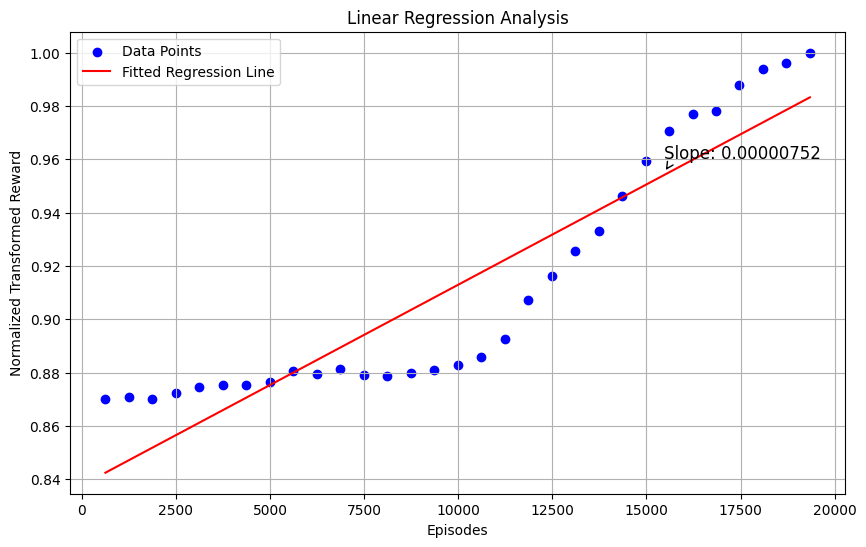

In [6]:
import matplotlib.pyplot as plt
df['Predicted'] = model.predict(X)  # Predicted values for the regression line

plt.figure(figsize=(10, 6))
plt.scatter(df['Episodes'], df['Normalized Transformed Reward'], color='blue', label='Data Points')
plt.plot(df['Episodes'], df['Predicted'], color='red', label='Fitted Regression Line')

# Calculate a position for the annotation
x_pos = df['Episodes'].max() * 0.8  # 80% along the x-axis range
y_pos = df['Predicted'].iloc[(df['Episodes'].searchsorted(x_pos))]  # corresponding y from the model

# Annotation for the slope
slope = model.params['Episodes']
plt.annotate(f'Slope: {slope:.8f}', xy=(x_pos, y_pos), textcoords="offset points", xytext=(0,10),
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.5"), fontsize=12)

plt.title('Linear Regression Analysis')
plt.xlabel('Episodes')
plt.ylabel('Normalized Transformed Reward')
plt.legend()
plt.grid()

plt.show()
